In [12]:
import os
import nltk
import re
import numpy as np
from hazm import word_tokenize, Lemmatizer, Stemmer, Normalizer
from pprint import pprint
import pandas as pd
from tensorflow import keras
from keras.preprocessing.text import Tokenizer


2022-05-03 20:15:25.939654: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-03 20:15:25.939733: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
raw_text = pd.read_csv('Shams_Corpus_Paper3.txt')
raw_text.iloc[5]

دیوان شمس تبریزی (غزلیات)    صورت دل صورت مخلوق نیست\tکز رخ دل حسن خدا رو نمود
Name: 5, dtype: object

In [45]:
file = open(os.getcwd() + "/Shams_Corpus_Paper3.txt", "rt")
raw_text = file.read()
file.close()


In [59]:
def remove_persian_stopword(tokens):
    file = open(os.getcwd() + "/persian_stopw.txt", "rt")
    raw_stop_words = file.read()
    file.close()

    stop_words = word_tokenize(raw_stop_words)

    return [word for word in tokens if not word in stop_words]

In [60]:
def normalize_text(text):
    normalizer = Normalizer()
    
    return normalizer.normalize(text)

In [61]:
def lemma_tokenizer(tokens):
    lemmatizer = Lemmatizer()    
    return [lemmatizer.lemmatize(token) for token in tokens]

In [62]:
def stem_tokenizer(tokens):
    stemmer = Stemmer()
    return [stemmer.stem(token) for token in tokens]

In [76]:
raw_text = "".join([i for i in raw_text if not i.isdigit()])
raw_text = re.sub(r"-+|\d+", "", raw_text)

raw_text = normalize_text(raw_text)

raw_tokens = word_tokenize(raw_text)
len(raw_tokens)

78389

In [77]:
type(raw_tokens)

list

In [89]:
tokens = remove_persian_stopword(raw_tokens)
len(tokens)

47335

In [146]:
t = Tokenizer()
t.fit_on_texts(tokens)

In [147]:
count_list = sorted(t.word_counts.items(), key=lambda x: x[1], reverse=True)
count_list[:20]

[('دل', 621),
 ('جان', 587),
 ('عشق', 455),
 ('سر', 390),
 ('شمس', 210),
 ('خوش', 187),
 ('آب', 179),
 ('دست', 175),
 ('سوی', 174),
 ('چشم', 171),
 ('خویش', 171),
 ('جهان', 167),
 ('صد', 165),
 ('یار', 162),
 ('دم', 154),
 ('روی', 145),
 ('شب', 143),
 ('کار', 141),
 ('رو', 140),
 ('مست', 138)]

In [119]:
lammatized_tokens = remove_persian_stopword(lemma_tokenizer(tokens))
print(len(lammatized_tokens))

stemmed_tokens = remove_persian_stopword(stem_tokenizer(tokens))
print(len(stemmed_tokens))

46732
45349


In [139]:
t = Tokenizer()
t.fit_on_texts(lammatized_tokens)
sorted_count_list = sorted(t.word_counts.items(), key=lambda x: x[1], reverse=True)

In [140]:
sorted_count_list[:20]

[('دل', 734),
 ('جان', 700),
 ('عشق', 508),
 ('سر', 426),
 ('دان', 276),
 ('کرد', 271),
 ('کن', 271),
 ('رو', 268),
 ('گو', 263),
 ('گشت', 249),
 ('گرد', 246),
 ('دانست', 238),
 ('بین', 233),
 ('دید', 225),
 ('مست', 220),
 ('سو', 215),
 ('گفت', 214),
 ('شمس', 213),
 ('چشم', 201),
 ('خوش', 200)]

In [141]:
len(t.word_index)

8437

In [143]:
def mapping(tokens):
    word_to_id = {}
    id_to_word = {}
    
    for i, token in enumerate(set(tokens)):
        word_to_id[token] = i
        id_to_word[i] = token
    
    return word_to_id, id_to_word

In [144]:
word_to_id, id_to_word = mapping(stemmed_tokens)
len(word_to_id)

8016

In [145]:
len(word_to_id)

8016

In [106]:
def concat(*iterables):
    for iterable in iterables:
        yield from iterable

In [107]:
def one_hot_encode(id, vocab_size):
    res = [0] * vocab_size
    res[id] = 1
    return res

In [108]:
import numpy as np

np.random.seed(42)


def generate_training_data(tokens, word_to_id, window):
    X = []
    y = []
    n_tokens = len(tokens)
    
    for i in range(n_tokens):
        idx = concat(
            range(max(0, i - window), i), 
            range(i, min(n_tokens, i + window + 1))
        )
        for j in idx:
            if i == j:
                continue
            X.append(one_hot_encode(word_to_id[tokens[i]], len(word_to_id)))
            y.append(one_hot_encode(word_to_id[tokens[j]], len(word_to_id)))
    
    return np.asarray(X), np.asarray(y)

In [112]:
X, y = generate_training_data(lammatized_tokens, word_to_id, 4)


In [75]:
print(y[5:9] ,sep = '\n')

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [76]:
print(X[5:9] ,sep = '\n')

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [113]:
X.shape

(11220, 905)

In [114]:
y.shape

(11220, 905)

In [79]:
def init_network(vocab_size, n_embedding):
    model = {
        "w1": np.random.randn(vocab_size, n_embedding),
        "w2": np.random.randn(n_embedding, vocab_size)
    }
    return model

In [115]:
model = init_network(len(word_to_id), 10)
model["w1"].shape

(905, 10)

In [116]:
model["w2"].shape

(10, 905)

In [82]:
def softmax(X):
    res = []
    for x in X:
        exp = np.exp(x)
        res.append(exp / exp.sum())
    return res

In [83]:
X.shape

(11220, 968)

In [84]:
(X @ model["w1"]).shape

(11220, 10)

In [85]:
(X @ model["w1"] @ model["w2"]).shape


(11220, 968)

In [36]:
def forward(model, X, return_cache=True):
    cache = {}
    
    cache["a1"] = X @ model["w1"]
    cache["a2"] = cache["a1"] @ model["w2"]
    cache["z"] = softmax(cache["a2"])
    
    if not return_cache:
        return cache["z"]
    return cache

In [37]:
def cross_entropy(z, y):
    return - np.sum(np.log(z) * y)

In [38]:
def backward(model, X, y, alpha):
    cache  = forward(model, X)
    da2 = cache["z"] - y
    dw2 = cache["a1"].T @ da2
    da1 = da2 @ model["w2"].T
    dw1 = X.T @ da1
    assert(dw2.shape == model["w2"].shape)
    assert(dw1.shape == model["w1"].shape)
    model["w1"] -= alpha * dw1
    model["w2"] -= alpha * dw2
    return cross_entropy(cache["z"], y)

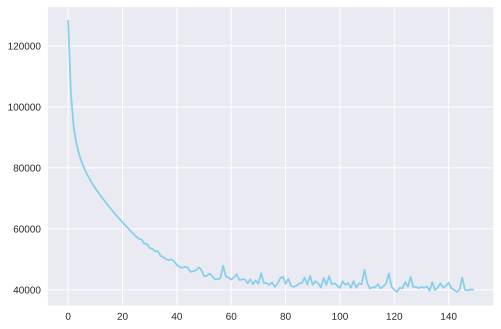

In [119]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use("seaborn")

model = init_network(len(word_to_id), 10)

n_iter = 150
learning_rate = 0.01

history = [backward(model, X, y, learning_rate) for _ in range(n_iter)]

plt.plot(range(len(history)), history, color="skyblue")
plt.show()

In [120]:
len(history)

150

In [51]:
np.argsort(result)[::-1][0:5]

array([ 15, 456, 179,  66, 263])

In [52]:
for word in (id_to_word[id] for id in np.argsort(result)[::-1][0:10]):
    print(word)


عشقت
فسردست
جمره
کنون
بگدازد
گرم
جانان
قد
بس
بنگرید


In [53]:
def get_word_similarities(word, model, n_similars=10):
    try:
        learning = one_hot_encode(word_to_id[word], len(word_to_id))
    except KeyError:
        print(f"Word = {word} is not in corpus")
        exit()
    result = forward(model, [learning], return_cache=False)[0]
    for word in (id_to_word[id] for id in np.argsort(result)[::-1][0:n_similars]):
        print(word)

    

In [159]:
def get_embedding(model, word):
    try:
        idx = word_to_id[word]
    except KeyError:
        print("`word` not in corpus")
    one_hot = one_hot_encode(idx, len(word_to_id))
    return forward(model, one_hot)["a1"]

In [160]:
get_embedding(model, "machine")


array([ 0.30857583, -0.26536961, -0.91359514, -0.00943186, -1.03899812,
       -0.81462034, -0.56576872, -1.75023053,  0.16655075, -0.03339144])

In [101]:
get_word_similarities('عیش', model, 10)

ایدک
خواجه
خامشان
سنایی
جدید
بمرد
دهل
عیش
الله
وگر


In [122]:
get_word_similarities('عیش', model, 10)

عیش
ایدک
ایا
جدید
دهل
سنایی
خام
تهیجنی
نضاره
وحوش


In [58]:
get_word_similarities('انگور', model, 20)

صافی
میخانه
فسرد
چونک
خوشه
انگور
خورشید
اجل
دوید
غرقه
ربود
کوی
دگران
بنگرید
پرتو
همگی
درد
اوفتاد
پر
صحرا


In [89]:
get_word_similarities('انگور', model, 20)

خورشید
اجل
فسرد
صافی
انگور
میخانه
خوشه
تن
چونک
طرب
نمود
رهید
پرتو
تافت
شکرش
خرف
نیست
فشرد
تبریز
او


In [123]:
get_word_similarities('انگور', model, 20)

تن
صاف
فسرد
اجل
میخانه
خوشه
انگور
چونک
خورشید
کشید#کش
فشرد
دست
همگی
پرتو
شنید#شنو
درد
زن
شبه
آفتاب
عاشق


In [62]:
get_word_similarities('بشر', model, 10)

قد
صدقه
محمود
باللقاء
بشر
دین
الکرام
نعم
حضرته
الکریم


In [88]:
get_word_similarities('بشر', model, 10)

صدقه
محمود
بذاک
حضرته
الکریم
باللقاء
یجعلنا
بشر
قد
مورود


In [124]:
get_word_similarities('بشر', model, 10)

محمود
حضرته
صدقه
بذاک
باللقاء
بشر
الکریم
یجعلنا
قد
حمدنا


In [99]:
get_word_similarities('ویرانه', model, 10)

باد
دید
وجود
عالم
جوید
جغدان
حلال
صد
ویرانه
باغ


In [125]:
get_word_similarities('ویرانه', model, 10)

دید
ویرانه
جهان
جست#جو
ماحضر
وجود
جغد
عالم
چشم
حلال
